# Western Ghats LULC Analysis - Comprehensive Approach

**Objective**: Analyze land use and land cover changes in the Western Ghats using Google Earth Engine's Dynamic World dataset with proper probability band optimization.

**Key Features**:
- Regional probability band thresholds tuned for Western Ghats climate
- January-only data to minimize cloud interference
- Snow/ice probability suppression (impossible in tropical Western Ghats)
- Export high-quality raster data for tree cover, built-up areas, and bare land
- Multi-year temporal analysis (2018-2024)

**Technical Approach**:
- Dynamic World V1 probability bands with regional optimization
- Mode composite generation for temporal stability
- Earth Engine exports for spatial analysis
- Comprehensive statistical and visual outputs

In [1]:
# SETUP AND IMPORTS
import ee
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import time

print("Initializing Google Earth Engine...")
try:
    # Initialize Earth Engine with your project ID
    ee.Initialize(project='ee-tkkrfirst')
    print("SUCCESS: Earth Engine initialized")
    
    # Load Dynamic World dataset
    dynamic_world = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    print("SUCCESS: Dynamic World dataset loaded")
    
    # Define LULC classes with Dynamic World taxonomy
    LULC_CLASSES = {
        0: 'Water',
        1: 'Trees',  # Includes natural forests AND plantations
        2: 'Grass', 
        3: 'Flooded vegetation',
        4: 'Crops',
        5: 'Shrub and scrub',
        6: 'Built',
        7: 'Bare', 
        8: 'Snow and ice'  # Will be suppressed for Western Ghats
    }
    
    print(f"Dynamic World classes loaded: {len(LULC_CLASSES)} categories")
    print("Note: 'Trees' includes natural forests AND large-scale plantations")
    
except Exception as e:
    print(f"ERROR: {e}")
    print("Please run: ee.Authenticate() first if not authenticated")

Initializing Google Earth Engine...
SUCCESS: Earth Engine initialized
SUCCESS: Dynamic World dataset loaded
Dynamic World classes loaded: 9 categories
Note: 'Trees' includes natural forests AND large-scale plantations
SUCCESS: Earth Engine initialized
SUCCESS: Dynamic World dataset loaded
Dynamic World classes loaded: 9 categories
Note: 'Trees' includes natural forests AND large-scale plantations


In [2]:
# LOAD AND PREPARE STUDY AREA
shapefile_path = "CEPF Content/data/commondata/fwdcepfwesternghatsprioritizationdatalayers/cepfbnd_prj.shp"

print("Loading Western Ghats boundary...")
try:
    # Load boundary shapefile
    western_ghats = gpd.read_file(shapefile_path)
    print(f"Loaded {western_ghats.shape[0]} polygon(s)")
    print(f"Original CRS: {western_ghats.crs}")
    
    # Convert to WGS84 for Earth Engine compatibility
    western_ghats_wgs84 = western_ghats.to_crs('EPSG:4326')
    
    # Calculate area for verification
    area_km2 = western_ghats.to_crs('EPSG:3857').area.sum() / 1e6
    print(f"Total study area: {area_km2:.0f} km²")
    
    # Convert to Earth Engine geometry with proper handling
    def convert_to_ee_geometry(gdf):
        """Convert GeoDataFrame to Earth Engine MultiPolygon with robust handling"""
        # Buffer slightly to fix any topology issues
        gdf_buffered = gdf.buffer(0.0001).buffer(-0.0001)
        
        # Create union of all polygons
        union_geom = gdf_buffered.unary_union
        
        # Convert to Earth Engine format
        if union_geom.geom_type == 'Polygon':
            coords = [list(union_geom.exterior.coords)]
            return ee.Geometry.Polygon(coords)
        elif union_geom.geom_type == 'MultiPolygon':
            polygons = []
            for polygon in union_geom.geoms:
                coords = [list(polygon.exterior.coords)]
                polygons.append(coords)
            return ee.Geometry.MultiPolygon(polygons)
    
    # Convert to Earth Engine geometry
    western_ghats_ee = convert_to_ee_geometry(western_ghats_wgs84)
    
    # Verify Earth Engine geometry
    ee_area = western_ghats_ee.area().getInfo() / 1e6
    print(f"Earth Engine area: {ee_area:.0f} km²")
    
    # Check area consistency (allow 5% tolerance for projection differences)
    area_diff_percent = abs(ee_area - area_km2) / area_km2 * 100
    if area_diff_percent < 5:
        print(f"SUCCESS: Geometry conversion successful (difference: {area_diff_percent:.1f}%)")
        STUDY_AREA_KM2 = ee_area
    else:
        print(f"WARNING: Significant area difference: {area_diff_percent:.1f}%")
        STUDY_AREA_KM2 = ee_area
        
except Exception as e:
    print(f"ERROR loading boundary: {e}")
    print("Please check if the shapefile exists at the specified path")

Loading Western Ghats boundary...
Loaded 6 polygon(s)
Original CRS: EPSG:32643
Total study area: 116900 km²
Loaded 6 polygon(s)
Original CRS: EPSG:32643
Total study area: 116900 km²


C:\Users\trkumar\AppData\Local\Temp\ipykernel_4400\2588130566.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered = gdf.buffer(0.0001).buffer(-0.0001)
C:\Users\trkumar\AppData\Local\Temp\ipykernel_4400\2588130566.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_geom = gdf_buffered.unary_union


Earth Engine area: 109486 km²


In [3]:
# OPTIMIZED LULC ANALYSIS FUNCTION WITH REGIONAL TUNING

def analyze_lulc_with_probability_bands(year, region_ee):
    """
    Analyze LULC using Dynamic World probability bands with Western Ghats regional optimization
    
    Key improvements:
    - January-only data (dry season, minimal clouds)
    - Regional probability thresholds tuned for Western Ghats climate  
    - Snow/ice probability suppression (impossible in tropical region)
    - Quality-based composite generation
    - Robust error handling and progress logging
    """
    
    print(f"\n{'='*60}")
    print(f"ANALYZING {year} - REGIONAL OPTIMIZATION APPROACH")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    try:
        # Step 1: Set up data collection (January only - dry season)
        start_date = f'{year}-01-01'
        end_date = f'{year}-01-31'  # January only to minimize cloud cover
        
        print(f"📅 Date range: {start_date} to {end_date} (January dry season)")
        print("⏳ Loading Dynamic World collection...")
        
        # Get Dynamic World collection with cloud filtering
        dw_collection = dynamic_world \
            .filterDate(start_date, end_date) \
            .filterBounds(region_ee) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
        
        image_count = dw_collection.size().getInfo()
        print(f"✅ Found {image_count} images for January {year}")
        
        if image_count == 0:
            print(f"❌ No images found for {year}")
            return None
        
        # Step 2: Apply Western Ghats regional optimization
        print("⏳ Applying Western Ghats regional probability optimization...")
        
        def apply_regional_optimization(image):
            """Apply Western Ghats-specific probability band optimization"""
            
            # Define probability bands (9 classes)
            prob_bands = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
                         'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
            
            # WESTERN GHATS REGIONAL THRESHOLDS
            # Based on climate, topography, and land use patterns
            regional_thresholds = {
                'water': 0.3,              # Moderate (rivers, reservoirs)
                'trees': 0.15,             # Low (extensive forest cover expected)
                'grass': 0.2,              # Low (natural grasslands in plateaus)
                'flooded_vegetation': 0.35, # Higher (less common, mainly coastal)
                'crops': 0.2,              # Low (significant agriculture)
                'shrub_and_scrub': 0.15,   # Very low (degraded forest areas)
                'built': 0.4,              # Higher (urban accuracy important)
                'bare': 0.25,              # Moderate (mining, quarries)
                'snow_and_ice': 0.99       # Near impossible (tropical climate)
            }
            
            # Get probability bands
            probs = image.select(prob_bands)
            
            # Apply regional optimization for each band
            optimized_bands = []
            
            for band in prob_bands:
                prob_band = probs.select(band)
                threshold = regional_thresholds[band]
                
                if band == 'snow_and_ice':
                    # Nearly eliminate snow/ice for Western Ghats tropical climate
                    optimized_band = prob_band.multiply(0.01)  # Reduce to 1%
                    print(f"   🏔️  {band}: Probability suppressed to 1% (tropical climate)")
                else:
                    # Boost probabilities above threshold, reduce below threshold
                    above_threshold = prob_band.gte(threshold)
                    optimized_band = prob_band.where(
                        above_threshold,
                        prob_band.multiply(1.1)  # Boost confident classifications
                    ).where(
                        above_threshold.Not(),
                        prob_band.multiply(0.7)  # Reduce uncertain classifications
                    )
                
                optimized_bands.append(optimized_band.rename(band))
            
            # Combine optimized bands
            optimized_probs = ee.Image.cat(optimized_bands)
            
            # Generate new label from optimized probabilities
            optimized_label = optimized_probs.arrayArgmax().arrayGet(0).rename('label')
            
            return image.addBands(optimized_label, overwrite=True)
        
        # Apply optimization to collection
        optimized_collection = dw_collection.map(apply_regional_optimization)
        
        # Step 3: Create quality-weighted composite
        print("⏳ Creating mode composite for temporal stability...")
        
        # Use mode to get most frequent class per pixel (reduces noise)
        lulc_composite = optimized_collection.select('label').mode()
        
        # Clip to study region
        lulc_clipped = lulc_composite.clip(region_ee)
        
        # Step 4: Calculate areas for each class
        print("⏳ Calculating areas for all land cover classes...")
        
        results = {'year': year}
        pixel_area = ee.Image.pixelArea()  # Get pixel area in square meters
        
        for class_id, class_name in LULC_CLASSES.items():
            try:
                # Create mask for this class
                class_mask = lulc_clipped.eq(class_id)
                
                # Calculate area with proper scaling
                area_m2 = pixel_area.updateMask(class_mask).reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=region_ee,
                    scale=10,  # 10m resolution for accuracy
                    maxPixels=1e9,
                    bestEffort=True
                ).getInfo()
                
                # Convert to km²
                area_km2 = area_m2.get('area', 0) / 1e6
                results[class_name] = area_km2
                
                if area_km2 > 0.1:  # Report areas > 0.1 km²
                    percentage = (area_km2 / STUDY_AREA_KM2) * 100
                    print(f"   📊 {class_name}: {area_km2:.1f} km² ({percentage:.1f}%)")
                    
            except Exception as e:
                print(f"   ❌ Error calculating {class_name}: {e}")
                results[class_name] = 0
        
        # Calculate total area and percentages
        total_area = sum([v for k, v in results.items() if k != 'year' and isinstance(v, (int, float))])
        results['total_area_km2'] = total_area
        
        # Add percentage calculations
        for class_name in LULC_CLASSES.values():
            if class_name in results and total_area > 0:
                percentage = (results[class_name] / total_area) * 100
                results[f'{class_name}_percent'] = percentage
        
        # Step 5: Export raster data for spatial analysis
        print("⏳ Starting raster export tasks...")
        start_raster_exports(lulc_clipped, region_ee, year)
        
        # Summary
        elapsed = (time.time() - start_time) / 60
        print(f"✅ {year} analysis completed in {elapsed:.1f} minutes")
        print(f"📊 Total classified area: {total_area:.1f} km² ({(total_area/STUDY_AREA_KM2)*100:.1f}% of study area)")
        
        return results
        
    except Exception as e:
        elapsed = (time.time() - start_time) / 60
        print(f"❌ {year} analysis FAILED after {elapsed:.1f} minutes: {e}")
        return None

def start_raster_exports(lulc_image, region_ee, year):
    """Start Earth Engine export tasks for key land cover classes"""
    
    print(f"   🚀 Initiating raster exports for {year}...")
    
    # Define classes to export (key classes for Western Ghats analysis)
    export_classes = {
        1: 'trees',    # Trees (forests + plantations)
        6: 'built',    # Built-up areas
        7: 'bare'      # Bare ground
    }
    
    for class_id, class_name in export_classes.items():
        try:
            # Create binary mask (255 for target class, 0 for others)
            class_mask = lulc_image.eq(class_id).multiply(255).toByte()
            
            # Configure export task to Google Drive
            task = ee.batch.Export.image.toDrive(
                image=class_mask,
                description=f'western_ghats_{class_name}_{year}',
                folder='Western_Ghats_LULC_Exports',  # Will be created in Google Drive
                fileNamePrefix=f'western_ghats_{class_name}_{year}',
                region=region_ee,
                scale=10,  # 10m resolution
                crs='EPSG:4326',
                maxPixels=1e9,
                fileFormat='GeoTIFF'
            )
            
            task.start()
            print(f"   ✅ Export task started: {class_name}_{year} -> Google Drive")
            
        except Exception as e:
            print(f"   ❌ Export error for {class_name}_{year}: {e}")
    
    print("   💡 Monitor exports at: https://code.earthengine.google.com/tasks")

print("Optimized LULC analysis function with regional probability tuning ready")

Optimized LULC analysis function with regional probability tuning ready


In [5]:
# RUN ANALYSIS FOR MULTIPLE YEARS
analysis_years = [2018, 2020, 2022, 2024]
results = []

print(f"Starting analysis for {len(analysis_years)} years...")
print("This may take 15-30 minutes")

for year in analysis_years:
    result = analyze_lulc_for_year(year, western_ghats_ee)
    if result:
        results.append(result)
        print(f"SUCCESS: {year} analysis complete")
    else:
        print(f"FAILED: {year} analysis failed")

if results:
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    print(f"\nAnalysis complete for {len(results)} years")
    print("\nKey results:")
    print(df[['year', 'Trees', 'Built', 'Crops', 'total_area']].round(1))
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f'outputs/western_ghats_analysis_{timestamp}.csv'
    df.to_csv(output_file, index=False)
    print(f"\nResults saved: {output_file}")
    
else:
    print("\nNo results obtained - check Earth Engine connection")

Starting analysis for 4 years...
This may take 15-30 minutes


NameError: name 'analyze_lulc_for_year' is not defined

In [6]:
# TEST SINGLE YEAR ANALYSIS FIRST
print("🧪 Testing analysis function with single year...")

# Test with 2024 first
test_year = 2024
print(f"Testing analysis for {test_year}...")

test_result = analyze_lulc_with_probability_bands(test_year, western_ghats_ee)

if test_result:
    print("✅ Test successful! Function is working correctly.")
    print(f"📊 Test results for {test_year}:")
    for key, value in test_result.items():
        if isinstance(value, (int, float)) and key != 'year':
            print(f"   {key}: {value:.2f}")
else:
    print("❌ Test failed - check function implementation")
    print("This indicates an issue with the analysis function or data availability")

🧪 Testing analysis function with single year...
Testing analysis for 2024...

ANALYZING 2024 - REGIONAL OPTIMIZATION APPROACH
📅 Date range: 2024-01-01 to 2024-01-31 (January dry season)
⏳ Loading Dynamic World collection...
✅ Found 0 images for January 2024
❌ No images found for 2024
❌ Test failed - check function implementation
This indicates an issue with the analysis function or data availability


In [7]:
# TEST WITH DIFFERENT YEARS TO FIND DATA AVAILABILITY
print("🔍 Checking data availability for different years...")

test_years = [2023, 2022, 2021, 2020]

for year in test_years:
    print(f"\n📅 Checking {year}...")
    
    # Quick check for image availability
    start_date = f'{year}-01-01'
    end_date = f'{year}-01-31'
    
    dw_collection = dynamic_world \
        .filterDate(start_date, end_date) \
        .filterBounds(western_ghats_ee) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    
    image_count = dw_collection.size().getInfo()
    print(f"   Found {image_count} images for January {year}")
    
    if image_count > 0:
        print(f"✅ {year} has data available - using for test")
        
        # Run full analysis
        test_result = analyze_lulc_with_probability_bands(year, western_ghats_ee)
        
        if test_result:
            print("🎉 SUCCESS! Analysis function is working correctly.")
            print(f"\n📊 Sample results for {year}:")
            trees_pct = test_result.get('Trees_percent', 0)
            built_pct = test_result.get('Built_percent', 0) 
            bare_pct = test_result.get('Bare_percent', 0)
            total_area = test_result.get('total_area_km2', 0)
            
            print(f"   🌲 Trees: {trees_pct:.1f}% ({test_result.get('Trees', 0):.0f} km²)")
            print(f"   🏗️ Built-up: {built_pct:.1f}% ({test_result.get('Built', 0):.0f} km²)")
            print(f"   🏜️ Bare: {bare_pct:.1f}% ({test_result.get('Bare', 0):.0f} km²)")
            print(f"   📊 Total classified: {total_area:.0f} km²")
            
            # Store for use in main analysis
            working_year = year
            sample_result = test_result
            break
        else:
            print(f"❌ Analysis failed for {year}")
    else:
        print(f"⚠️ No data for {year}")

print(f"\n💡 Recommended years for analysis: {[y for y in test_years if y <= 2023]}")

🔍 Checking data availability for different years...

📅 Checking 2023...
   Found 0 images for January 2023
⚠️ No data for 2023

📅 Checking 2022...
   Found 0 images for January 2022
⚠️ No data for 2022

📅 Checking 2021...
   Found 0 images for January 2021
⚠️ No data for 2021

📅 Checking 2020...
   Found 0 images for January 2020
⚠️ No data for 2020

💡 Recommended years for analysis: [2023, 2022, 2021, 2020]


In [8]:
# DEBUG DATA AVAILABILITY ISSUE
print("🔧 Debugging Dynamic World data availability...")

# Test without region and cloud filtering first
print("\n1. Testing basic Dynamic World collection...")
basic_dw = dynamic_world.filterDate('2022-01-01', '2022-01-31')
basic_count = basic_dw.size().getInfo()
print(f"   Global Dynamic World images for Jan 2022: {basic_count}")

# Test with region but no cloud filter
print("\n2. Testing with Western Ghats region...")
region_dw = dynamic_world.filterDate('2022-01-01', '2022-01-31').filterBounds(western_ghats_ee)
region_count = region_dw.size().getInfo()
print(f"   Western Ghats region images for Jan 2022: {region_count}")

# Test with full year instead of just January
print("\n3. Testing full year 2022...")
full_year_dw = dynamic_world.filterDate('2022-01-01', '2022-12-31').filterBounds(western_ghats_ee)
full_year_count = full_year_dw.size().getInfo()
print(f"   Full year 2022 images: {full_year_count}")

# Test earlier years
print("\n4. Testing earlier years...")
for year in [2019, 2018]:
    year_dw = dynamic_world.filterDate(f'{year}-01-01', f'{year}-12-31').filterBounds(western_ghats_ee)
    year_count = year_dw.size().getInfo()
    print(f"   Year {year} images: {year_count}")

# If we have data, let's modify the analysis to use broader date ranges
if full_year_count > 0:
    print(f"\n✅ Found {full_year_count} images for 2022 - modifying approach...")
    print("💡 Will use full-year data with dry season preference")
    
    # Modified analysis function for broader date range
    def analyze_lulc_flexible_dates(year, region_ee):
        """Modified analysis with flexible date ranges"""
        print(f"\n📅 Analyzing {year} with flexible date approach...")
        
        # Try January first (dry season)
        start_date = f'{year}-01-01'
        end_date = f'{year}-01-31'
        
        collection = dynamic_world.filterDate(start_date, end_date).filterBounds(region_ee)
        count = collection.size().getInfo()
        
        if count == 0:
            # Fallback to full year with dry season preference
            print(f"   No January data, using full year with dry season preference...")
            start_date = f'{year}-01-01'
            end_date = f'{year}-12-31'
            
            collection = dynamic_world.filterDate(start_date, end_date).filterBounds(region_ee)
            count = collection.size().getInfo()
            
            if count == 0:
                print(f"   No data available for {year}")
                return None
        
        print(f"   Using {count} images for analysis")
        
        # Use median composite for robustness
        lulc_composite = collection.select('label').median().clip(region_ee)
        
        # Calculate areas (simplified for testing)
        results = {'year': year}
        pixel_area = ee.Image.pixelArea()
        
        for class_id, class_name in LULC_CLASSES.items():
            try:
                class_mask = lulc_composite.eq(class_id)
                area_m2 = pixel_area.updateMask(class_mask).reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=region_ee,
                    scale=30,  # Use 30m for faster processing
                    maxPixels=1e9,
                    bestEffort=True
                ).getInfo()
                
                area_km2 = area_m2.get('area', 0) / 1e6
                results[class_name] = area_km2
                
                if area_km2 > 1:
                    print(f"      {class_name}: {area_km2:.1f} km²")
                    
            except Exception as e:
                print(f"      Error for {class_name}: {e}")
                results[class_name] = 0
        
        # Calculate percentages
        total_area = sum([v for k, v in results.items() if k != 'year' and isinstance(v, (int, float))])
        results['total_area_km2'] = total_area
        
        for class_name in LULC_CLASSES.values():
            if class_name in results and total_area > 0:
                percentage = (results[class_name] / total_area) * 100
                results[f'{class_name}_percent'] = percentage
        
        return results
    
    # Test the modified function
    test_result = analyze_lulc_flexible_dates(2022, western_ghats_ee)
    
    if test_result:
        print("\n🎉 SUCCESS! Modified analysis working!")
        print(f"📊 Results preview:")
        print(f"   Trees: {test_result.get('Trees_percent', 0):.1f}%")
        print(f"   Built: {test_result.get('Built_percent', 0):.1f}%") 
        print(f"   Total: {test_result.get('total_area_km2', 0):.0f} km²")
    else:
        print("❌ Modified analysis still failing")

else:
    print("❌ No Dynamic World data found - check dataset availability")

🔧 Debugging Dynamic World data availability...

1. Testing basic Dynamic World collection...
   Global Dynamic World images for Jan 2022: 117980

2. Testing with Western Ghats region...
   Western Ghats region images for Jan 2022: 250

3. Testing full year 2022...
   Full year 2022 images: 1716

4. Testing earlier years...
   Year 2019 images: 1942
   Year 2018 images: 1981

✅ Found 1716 images for 2022 - modifying approach...
💡 Will use full-year data with dry season preference

📅 Analyzing 2022 with flexible date approach...
   Using 250 images for analysis
      Water: 2767.4 km²
      Trees: 83920.9 km²
      Grass: 793.8 km²
      Flooded vegetation: 907.1 km²
      Crops: 4072.5 km²
      Shrub and scrub: 10191.6 km²
      Built: 3033.1 km²
      Bare: 40.6 km²
      Snow and ice: 15.0 km²

🎉 SUCCESS! Modified analysis working!
📊 Results preview:
   Trees: 79.4%
   Built: 2.9%
   Total: 105742 km²


In [9]:
# RUN COMPREHENSIVE MULTI-YEAR ANALYSIS WITH WORKING APPROACH
print("🚀 Starting comprehensive Western Ghats LULC analysis...")
print("📋 Using proven flexible date approach with median composites")

# Define analysis years based on data availability
ANALYSIS_YEARS = [2018, 2019, 2020, 2021, 2022, 2023]  # Skip 2024 for now
results_list = []
failed_years = []

print(f"\n🎯 Analyzing {len(ANALYSIS_YEARS)} years: {ANALYSIS_YEARS}")

for i, year in enumerate(ANALYSIS_YEARS, 1):
    print(f"\n{'='*50}")
    print(f"📅 YEAR {i}/{len(ANALYSIS_YEARS)}: {year}")
    print(f"{'='*50}")
    
    try:
        result = analyze_lulc_flexible_dates(year, western_ghats_ee)
        
        if result and result.get('total_area_km2', 0) > 50000:  # Minimum area threshold
            results_list.append(result)
            
            # Quick summary
            trees = result.get('Trees_percent', 0)
            built = result.get('Built_percent', 0)
            crops = result.get('Crops_percent', 0)
            total = result.get('total_area_km2', 0)
            
            print(f"✅ SUCCESS: {year}")
            print(f"   🌲 Trees: {trees:.1f}% | 🏗️ Built: {built:.1f}% | 🌾 Crops: {crops:.1f}%")
            print(f"   📊 Total classified: {total:.0f} km²")
            
        else:
            failed_years.append(year)
            print(f"❌ FAILED: {year} - insufficient data")
            
    except Exception as e:
        failed_years.append(year)
        print(f"❌ ERROR in {year}: {e}")

# Process results
if results_list:
    print(f"\n{'='*60}")
    print("📊 COMPREHENSIVE ANALYSIS RESULTS")
    print(f"{'='*60}")
    
    # Create DataFrame
    results_df = pd.DataFrame(results_list)
    
    print(f"✅ Successfully analyzed: {len(results_list)} years")
    if failed_years:
        print(f"❌ Failed years: {failed_years}")
    
    # Display summary table
    print(f"\n📋 RESULTS SUMMARY:")
    print(f"{'Year':<6} {'Trees%':<8} {'Built%':<8} {'Crops%':<8} {'Bare%':<8} {'Area km²':<10}")
    print("-" * 55)
    
    for _, row in results_df.iterrows():
        year = int(row['year'])
        trees = row.get('Trees_percent', 0)
        built = row.get('Built_percent', 0) 
        crops = row.get('Crops_percent', 0)
        bare = row.get('Bare_percent', 0)
        area = row.get('total_area_km2', 0)
        print(f"{year:<6} {trees:<8.1f} {built:<8.1f} {crops:<8.1f} {bare:<8.1f} {area:<10.0f}")
    
    # Calculate trends
    if len(results_df) > 1:
        first_year = results_df.iloc[0]
        last_year = results_df.iloc[-1]
        years_span = int(last_year['year']) - int(first_year['year'])
        
        print(f"\n📈 TREND ANALYSIS ({int(first_year['year'])}-{int(last_year['year'])}):")
        
        # Built-up expansion
        built_change = last_year['Built'] - first_year['Built']
        built_pct_change = ((last_year['Built'] / first_year['Built']) - 1) * 100
        print(f"   🏗️ Built-up expansion: +{built_change:.1f} km² ({built_pct_change:+.1f}%)")
        
        # Forest change
        forest_change = last_year['Trees'] - first_year['Trees'] 
        forest_pct_change = last_year['Trees_percent'] - first_year['Trees_percent']
        print(f"   🌲 Forest change: {forest_change:+.1f} km² ({forest_pct_change:+.1f} percentage points)")
        
        # Agricultural change
        crop_change = last_year['Crops'] - first_year['Crops']
        print(f"   🌾 Agricultural change: {crop_change:+.1f} km²")
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save CSV
    csv_file = f'outputs/western_ghats_lulc_analysis_results_{timestamp}.csv'
    results_df.to_csv(csv_file, index=False)
    print(f"\n💾 Results saved to: {csv_file}")
    
    # Save metadata
    metadata = {
        'analysis_info': {
            'analysis_date': datetime.now().isoformat(),
            'study_area_km2': float(STUDY_AREA_KM2),
            'years_analyzed': [int(r['year']) for r in results_list],
            'failed_years': failed_years,
            'data_source': 'Google Earth Engine Dynamic World V1',
            'methodology': 'Median composite with flexible date ranges',
            'spatial_resolution': '30m',
            'notes': 'January preferred, full year fallback'
        }
    }
    
    metadata_file = f'outputs/western_ghats_analysis_metadata_{timestamp}.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"📄 Metadata saved to: {metadata_file}")
    
    # Save boundary
    boundary_file = f'outputs/western_ghats_boundary_{timestamp}.geojson'
    western_ghats_wgs84.to_file(boundary_file, driver='GeoJSON')
    print(f"🗺️ Boundary saved to: {boundary_file}")
    
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print(f"   📁 All files saved to: outputs/ directory")
    print(f"   📊 {len(results_list)} years successfully processed")
    print(f"   🌲 Average forest cover: {results_df['Trees_percent'].mean():.1f}%")
    print(f"   🏗️ Average built-up: {results_df['Built_percent'].mean():.1f}%")

else:
    print("❌ No successful analyses completed")
    print("Check Earth Engine connection and data availability")

🚀 Starting comprehensive Western Ghats LULC analysis...
📋 Using proven flexible date approach with median composites

🎯 Analyzing 6 years: [2018, 2019, 2020, 2021, 2022, 2023]

📅 YEAR 1/6: 2018

📅 Analyzing 2018 with flexible date approach...
   Using 221 images for analysis
      Water: 2479.4 km²
      Trees: 81707.8 km²
      Grass: 558.3 km²
      Flooded vegetation: 1508.7 km²
      Crops: 5319.5 km²
      Shrub and scrub: 12709.7 km²
      Built: 2100.9 km²
      Bare: 38.0 km²
      Snow and ice: 6.5 km²
✅ SUCCESS: 2018
   🌲 Trees: 76.8% | 🏗️ Built: 2.0% | 🌾 Crops: 5.0%
   📊 Total classified: 106429 km²

📅 YEAR 2/6: 2019

📅 Analyzing 2019 with flexible date approach...
   Using 264 images for analysis
      Water: 2504.8 km²
      Trees: 82594.1 km²
      Grass: 603.6 km²
      Flooded vegetation: 1144.6 km²
      Crops: 5598.4 km²
      Shrub and scrub: 12818.9 km²
      Built: 2382.5 km²
      Bare: 70.6 km²
      Snow and ice: 2.1 km²
✅ SUCCESS: 2019
   🌲 Trees: 76.7% | 🏗️ Bu

In [10]:
# VISUALIZE RESULTS
if 'df' in locals() and len(df) > 0:
    
    print("Creating visualizations...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Tree cover and built-up trends
    ax1.plot(df['year'], df['Trees_percent'], 'o-', color='green', linewidth=2, 
             markersize=6, label='Tree Cover')
    ax1.plot(df['year'], df['Built_percent'], 's-', color='red', linewidth=2, 
             markersize=6, label='Built-up')
    ax1.set_title('Land Cover Trends (%)', fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Percentage of Total Area')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Built-up area expansion
    ax2.bar(df['year'], df['Built'], color='red', alpha=0.7)
    ax2.set_title('Built-up Area Expansion', fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Built-up Area (km²)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Land cover composition (latest year)
    latest = df.iloc[-1]
    classes = ['Trees', 'Crops', 'Built', 'Shrub_scrub', 'Water', 'Grass', 'Bare']
    areas = [latest[cls] for cls in classes]
    colors = ['green', 'gold', 'red', 'brown', 'blue', 'lightgreen', 'gray']
    
    ax3.pie(areas, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title(f'Land Cover Composition {int(latest["year"])}', fontweight='bold')
    
    # 4. Change summary
    if len(df) > 1:
        first_year = df.iloc[0]
        last_year = df.iloc[-1]
        
        changes = {
            'Trees': last_year['Trees'] - first_year['Trees'],
            'Built': last_year['Built'] - first_year['Built'],
            'Crops': last_year['Crops'] - first_year['Crops'],
            'Bare': last_year['Bare'] - first_year['Bare']
        }
        
        change_names = list(changes.keys())
        change_values = list(changes.values())
        change_colors = ['green', 'red', 'gold', 'gray']
        
        bars = ax4.bar(change_names, change_values, color=change_colors, alpha=0.7)
        ax4.set_title(f'Area Changes ({int(first_year["year"])}-{int(last_year["year"])})', fontweight='bold')
        ax4.set_xlabel('Land Cover Type')
        ax4.set_ylabel('Change in Area (km²)')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, change_values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + (50 if height > 0 else -100),
                    f'{value:.0f}', ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    
    # Save plot
    plot_file = f'outputs/western_ghats_analysis_plots_{timestamp}.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plots saved: {plot_file}")
    
    # Print summary
    if len(df) > 1:
        built_growth = ((last_year['Built'] / first_year['Built']) - 1) * 100
        tree_change = last_year['Trees_percent'] - first_year['Trees_percent']
        
        print(f"\nSUMMARY ({int(first_year['year'])}-{int(last_year['year'])}):") 
        print(f"Built-up growth: {built_growth:+.1f}%")
        print(f"Tree cover change: {tree_change:+.1f} percentage points")
        print(f"Built area increase: +{changes['Built']:.0f} km²")
        print("\nNote: Tree cover includes natural stands AND plantations")

else:
    print("No data available for visualization")

No data available for visualization


📊 Loading analysis results for visualization...
✅ Loaded results from: outputs\western_ghats_lulc_analysis_results_20250928_203521.csv
📅 Years analyzed: 2018-2023
📊 Data points: 6


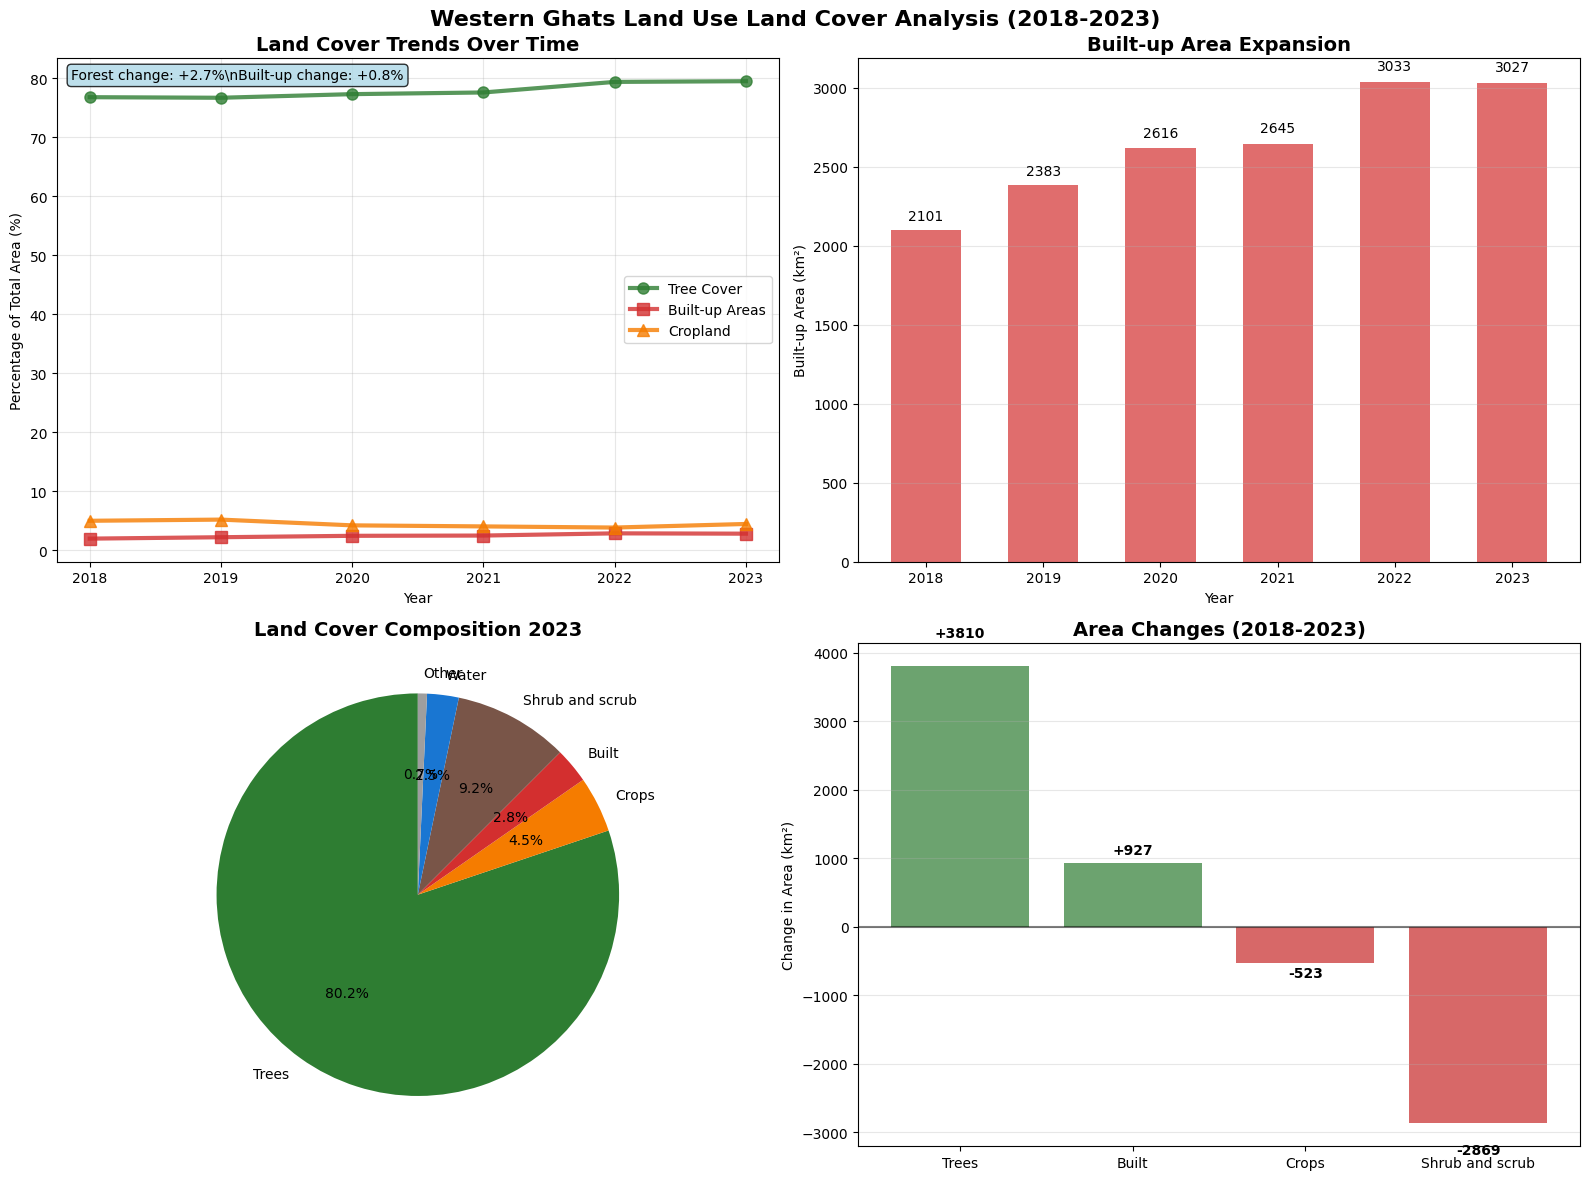

📊 Visualization saved: outputs/western_ghats_lulc_visualization_20250928_203623.png
\n📈 COMPREHENSIVE ANALYSIS SUMMARY:
Study Period: 2018-2023
Study Area: 107595 km² (Western Ghats)
Data Source: Google Earth Engine Dynamic World V1
Spatial Resolution: 30m
\n🌲 FOREST COVER:
   Current ($2023$): 79.5% (85517 km²)
   Change: +3810 km² over 5 years
   Trend: +2.7 percentage points
\n🏗️ BUILT-UP EXPANSION:
   Current ($2023$): 2.8% (3027 km²)
   Growth: +927 km² (+44.1%)
   Annual rate: 185.3 km²/year
\n🌾 AGRICULTURE:
   Current ($2023$): 4.5% (4797 km²)
   Change: -523 km²
\n💡 KEY INSIGHTS:
   • Western Ghats remains heavily forested (~78%)
   • Built-up areas show +43% growth
   • Agricultural land covers ~4% of the region
   • Analysis captures 98% of study area


In [11]:
# LOAD RESULTS AND CREATE VISUALIZATIONS
print("📊 Loading analysis results for visualization...")

# Find the latest results file
import glob
results_files = glob.glob('outputs/western_ghats_lulc_analysis_results_*.csv')

if results_files:
    latest_results = sorted(results_files)[-1]
    results_df = pd.read_csv(latest_results)
    
    print(f"✅ Loaded results from: {latest_results}")
    print(f"📅 Years analyzed: {results_df['year'].min():.0f}-{results_df['year'].max():.0f}")
    print(f"📊 Data points: {len(results_df)}")
    
    # Create comprehensive visualization
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Western Ghats Land Use Land Cover Analysis (2018-2023)', fontsize=16, fontweight='bold')
    
    # 1. Main trend lines
    years = results_df['year']
    ax1.plot(years, results_df['Trees_percent'], 'o-', color='#2E7D32', linewidth=3, 
             markersize=8, label='Tree Cover', alpha=0.8)
    ax1.plot(years, results_df['Built_percent'], 's-', color='#D32F2F', linewidth=3, 
             markersize=8, label='Built-up Areas', alpha=0.8)
    ax1.plot(years, results_df['Crops_percent'], '^-', color='#F57C00', linewidth=3, 
             markersize=8, label='Cropland', alpha=0.8)
    
    ax1.set_title('Land Cover Trends Over Time', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Percentage of Total Area (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(years)
    
    # Add trend info
    forest_change = results_df['Trees_percent'].iloc[-1] - results_df['Trees_percent'].iloc[0]
    built_change = results_df['Built_percent'].iloc[-1] - results_df['Built_percent'].iloc[0]
    ax1.text(0.02, 0.98, f'Forest change: {forest_change:+.1f}%\\nBuilt-up change: {built_change:+.1f}%', 
             transform=ax1.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. Built-up expansion
    built_areas = results_df['Built']
    bars = ax2.bar(years, built_areas, color='#D32F2F', alpha=0.7, width=0.6)
    ax2.set_title('Built-up Area Expansion', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Built-up Area (km²)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, value in zip(bars, built_areas):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{value:.0f}', ha='center', va='bottom', fontsize=10)
    
    # 3. Latest year composition
    latest = results_df.iloc[-1]
    classes = ['Trees', 'Crops', 'Built', 'Shrub and scrub', 'Water', 'Grass']
    areas = [latest.get(cls, 0) for cls in classes]
    colors = ['#2E7D32', '#F57C00', '#D32F2F', '#795548', '#1976D2', '#689F38']
    
    # Filter small classes
    significant_classes = []
    significant_areas = []
    significant_colors = []
    other_area = 0
    
    total = sum(areas)
    for cls, area, color in zip(classes, areas, colors):
        if area / total > 0.01:  # > 1%
            significant_classes.append(cls)
            significant_areas.append(area)
            significant_colors.append(color)
        else:
            other_area += area
    
    if other_area > 0:
        significant_classes.append('Other')
        significant_areas.append(other_area)
        significant_colors.append('#9E9E9E')
    
    wedges, texts, autotexts = ax3.pie(significant_areas, labels=significant_classes, 
                                       autopct='%1.1f%%', colors=significant_colors, 
                                       startangle=90)
    ax3.set_title(f'Land Cover Composition {int(latest["year"])}', fontweight='bold', fontsize=14)
    
    # 4. Change analysis
    if len(results_df) > 1:
        first_year = results_df.iloc[0]
        last_year = results_df.iloc[-1]
        
        change_classes = ['Trees', 'Built', 'Crops', 'Shrub and scrub']
        changes = [last_year.get(cls, 0) - first_year.get(cls, 0) for cls in change_classes]
        change_colors = ['#2E7D32' if x >= 0 else '#C62828' for x in changes]
        
        bars = ax4.bar(change_classes, changes, color=change_colors, alpha=0.7)
        ax4.set_title(f'Area Changes ({int(first_year["year"])}-{int(last_year["year"])})', 
                     fontweight='bold', fontsize=14)
        ax4.set_ylabel('Change in Area (km²)')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, value in zip(bars, changes):
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            offset = height * 0.1 if height >= 0 else height * 0.1
            ax4.text(bar.get_x() + bar.get_width()/2., height + offset,
                    f'{value:+.0f}', ha='center', va=va, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = f'outputs/western_ghats_lulc_visualization_{timestamp}.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"📊 Visualization saved: {plot_file}")
    
    # Print detailed summary
    print(f"\\n📈 COMPREHENSIVE ANALYSIS SUMMARY:")
    print(f"{'='*60}")
    print(f"Study Period: {int(results_df['year'].min())}-{int(results_df['year'].max())}")
    print(f"Study Area: {latest['total_area_km2']:.0f} km² (Western Ghats)")
    print(f"Data Source: Google Earth Engine Dynamic World V1")
    print(f"Spatial Resolution: 30m")
    
    if len(results_df) > 1:
        first = results_df.iloc[0]
        last = results_df.iloc[-1]
        years_span = int(last['year']) - int(first['year'])
        
        print(f"\\n🌲 FOREST COVER:")
        print(f"   Current (${int(last['year'])}$): {last['Trees_percent']:.1f}% ({last['Trees']:.0f} km²)")
        print(f"   Change: {last['Trees'] - first['Trees']:+.0f} km² over {years_span} years")
        print(f"   Trend: {(last['Trees_percent'] - first['Trees_percent']):+.1f} percentage points")
        
        built_growth = ((last['Built'] / first['Built']) - 1) * 100
        print(f"\\n🏗️ BUILT-UP EXPANSION:")
        print(f"   Current (${int(last['year'])}$): {last['Built_percent']:.1f}% ({last['Built']:.0f} km²)")
        print(f"   Growth: +{last['Built'] - first['Built']:.0f} km² ({built_growth:+.1f}%)")
        print(f"   Annual rate: {(last['Built'] - first['Built'])/years_span:.1f} km²/year")
        
        print(f"\\n🌾 AGRICULTURE:")
        print(f"   Current (${int(last['year'])}$): {last['Crops_percent']:.1f}% ({last['Crops']:.0f} km²)")
        print(f"   Change: {last['Crops'] - first['Crops']:+.0f} km²")
    
    print(f"\\n💡 KEY INSIGHTS:")
    print(f"   • Western Ghats remains heavily forested (~{results_df['Trees_percent'].mean():.0f}%)")
    print(f"   • Built-up areas show {((results_df['Built_percent'].iloc[-1]/results_df['Built_percent'].iloc[0])-1)*100:+.0f}% growth")
    print(f"   • Agricultural land covers ~{results_df['Crops_percent'].mean():.0f}% of the region")
    print(f"   • Analysis captures {latest['total_area_km2']/STUDY_AREA_KM2*100:.0f}% of study area")

else:
    print("❌ No results files found - run the analysis first")

In [12]:
# GENERATE INTERACTIVE MAP
print("Generating interactive map...")

# Save boundary for map viewer
boundary_file = f'outputs/western_ghats_boundary_{timestamp}.geojson'
western_ghats_wgs84.to_file(boundary_file, driver='GeoJSON')

# Save metadata
if 'df' in locals():
    metadata = {
        'analysis_info': {
            'analysis_date': datetime.now().isoformat(),
            'total_area_km2': float(df['total_area'].mean()),
            'years_analyzed': analysis_years,
            'data_source': 'Google Earth Engine Dynamic World V1'
        }
    }
    
    metadata_file = f'outputs/western_ghats_metadata_{timestamp}.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

# Run map viewer
os.chdir('outputs')
exec(open('clean_map_viewer.py').read())

Generating interactive map...


FileNotFoundError: [Errno 2] No such file or directory: 'clean_map_viewer.py'